参考https://zhuanlan.zhihu.com/p/15891909655 ， 我们基于python写一个小的有限元求解器。我们加入了更多的网格节点可视化，且修改了边界寻找的逻辑，使得更加简洁，提高效率。

我们要
求解 $\Omega=[-1,1] \times[-1,1]$ 上的 Poisson 方程：

$$
-\Delta u=f, x \in \Omega
$$


边界条件为 Dirichlet 条件，$u=0, x$ on $\partial \Omega$ 。
弱形式为

$$
\int_{\Omega} \nabla u \cdot \nabla v d x=\int_{\Omega} f v, \forall v \in V_h
$$


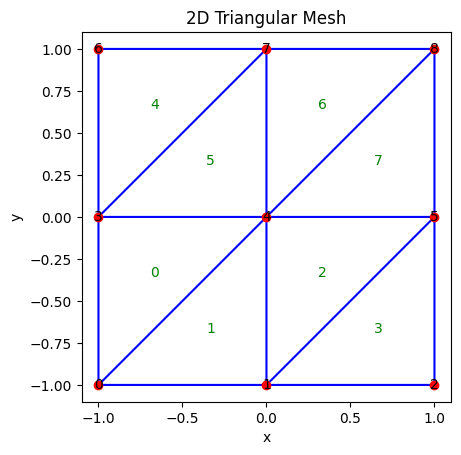

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve


initial_nodes = np.array([
    [-1, -1],
    [ 0, -1],
    [ 1, -1],
    [-1,  0],
    [ 0,  0],
    [ 1,  0],
    [-1,  1],
    [ 0,  1],
    [ 1,  1]
])

initial_elements = np.array([
    [4, 1, 5],
    [2, 5, 1],
    [5, 2, 6],
    [3, 6, 2],
    [7, 4, 8],
    [5, 8, 4],
    [8, 5, 9],
    [6, 9, 5]
]) - 1 

x = initial_nodes[:, 0]
y = initial_nodes[:, 1]

triang = tri.Triangulation(x, y, initial_elements)
# 可视化三角形网格
plt.triplot(triang, color='blue')
plt.scatter(x, y, color='red')

# 标注节点编号
for i, (x_i, y_i) in enumerate(initial_nodes):
    plt.text(x_i, y_i, str(i), color="black", fontsize=10, ha='center', va='center')

# 显示三角形编号（elem）
for idx, triangle in enumerate(initial_elements):
    # 计算三角形的中心位置
    centroid_x = np.mean(initial_nodes[triangle, 0])
    centroid_y = np.mean(initial_nodes[triangle, 1])
    # 在三角形中心标注编号
    plt.text(centroid_x, centroid_y, f'{idx}', color="green", fontsize=10, ha='center', va='center')
# 设置图像属性
plt.gca().set_aspect('equal')
plt.title("2D Triangular Mesh")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

为了提高求解精度，我们需要进行网格加密。将三角形单元剖分成更小的三角形：

1. 找到每一条边的中点，计算中点坐标
2. 因为有三角形共用一条边，要防止中点坐标重复

核心逻辑

在细化网格时，对于每个三角形，需要计算其三条边的中点。如果不加以控制，某些边会被重复计算（比如当两三角形共享一条边时）。为了避免重复计算，采用如下方法：

每条边用一个无向边 (i, j) 表示，其中 i 和 j 是边的两个顶点的索引。
为了确保 (i, j) 和 (j, i) 表示同一条边，使用 tuple(sorted((i, j))) 对边的两个顶点索引排序，使得 (i, j) 总是以小的顶点索引在前。
记录边的中点：

用一个字典 edge_midpoint 来存储每条边的中点索引，键是边 (i, j)，值是中点的索引。
在计算中点之前，先检查这条边是否已经存在于字典中：
如果存在，则直接取出中点的索引，避免重复计算。
如果不存在，则计算中点的坐标，添加到 new_node 列表中，并将中点的索引存入字典。

3. 将新三角形的信息放入 new_node, new_elem 中

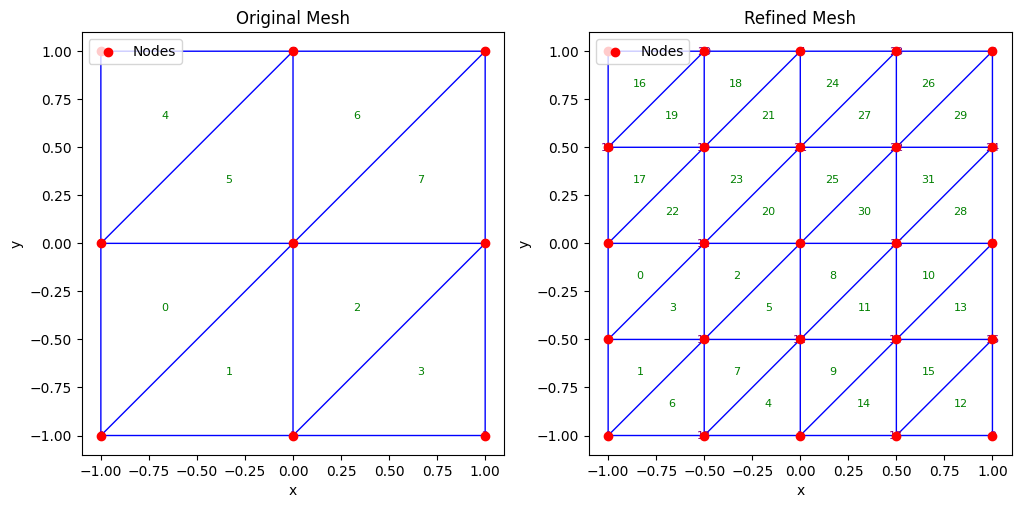

In [3]:
# refine a given mesh
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

def subdivide_mesh(nodes, elements):
    # input: old node and elem
    # output: new_node, new_elem
        updated_nodes = nodes.tolist()
        updated_elements = []
        midpoints = {}

        def get_midpoint_index(i, j):
            edge = tuple(sorted((i, j)))# 无向边
            if edge not in midpoints:#避免重复
                midpoint = (nodes[edge[0]] + nodes[edge[1]]) / 2
                midpoints[edge] = len(updated_nodes)
                updated_nodes.append(midpoint.tolist()) # 使用 list 动态变化
            return midpoints[edge] #获取中点索引
    
        # 构造 new_elem, 遍历每一个三角形，细化为四个小三角形

        for triangle in elements:
            i, j, k = triangle
            m1 = get_midpoint_index(i, j)
            m2 = get_midpoint_index(j, k)
            m3 = get_midpoint_index(k, i)
            updated_elements.extend([ # 使用 extend 而不是 append
                [i, m1, m3],
                [m1, j, m2],
                [m3, m2, k],
                [m1, m2, m3]
            ])
        return np.array(updated_nodes), np.array(updated_elements)

# 加密网格
# number of refinement
Nref = 1
refined_node, refined_elem = initial_nodes, initial_elements
for i in range(Nref):
    refined_node, refined_elem = subdivide_mesh(refined_node, refined_elem)

# 绘制网格并显示编号
def plot_mesh(node, elem, title):
    plt.triplot(node[:, 0], node[:, 1], elem, color='blue', lw=1)
    plt.scatter(node[:, 0], node[:, 1], color='red', zorder=5, label='Nodes')
    
    # 显示节点编号
    for idx, (x, y) in enumerate(node):
        plt.text(x, y, str(idx), color="purple", fontsize=8, ha='center', va='center')
    
    # 显示单元编号
    for idx, triangle in enumerate(elem):
        # 计算三角形的中心位置
        centroid = node[triangle].mean(axis=0)
        plt.text(centroid[0], centroid[1], str(idx), color="green", fontsize=8, ha='center', va='center')

    plt.gca().set_aspect('equal')
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()


# 绘制原始网格和细化网格
plt.figure(figsize=(12, 6))

# 原始网格
plt.subplot(1, 2, 1)
plot_mesh(initial_nodes, initial_elements, "Original Mesh")

# 细化后的网格
plt.subplot(1, 2, 2)
plot_mesh(refined_node, refined_elem, "Refined Mesh")

plt.show()

我们先组装一个单元的矩阵，再遍历所有的单元，采用稀疏矩阵的储存方式，最终组装成 global 矩阵。

如果采用线性的基函数：
$$
\begin{aligned}
& \phi_1(\boldsymbol{x})=1-x_1-x_2 \\
& \phi_2(\boldsymbol{x})=x_1 \\
& \phi_3(\boldsymbol{x})=x_2
\end{aligned}
$$

In [4]:
#展示基函数
import numpy as np
import matplotlib.pyplot as plt

# Define the grid
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)

# Basis functions
def phi_1(x, y):
    return 1 - x - y

def phi_2(x, y):
    return x

def phi_3(x, y):
    return y

构建从参考单元到其他单元的映射，
$F: \hat{\tau} \rightarrow \tau$：

$$
F(\hat{x})=B^T(\hat{x})+c
$$

其中 $B$ 和 $c$ 为

$$
\begin{aligned}
B & =\left(\begin{array}{ll}
x_1-x_3 & y_1-y_3 \\
x_2-x_3 & y_2-y_3
\end{array}\right) \\
c & =\left(x_3, y_3\right)^T .
\end{aligned}
$$

由此可以构建 Stiffness matrix，

$$
A_t=\int_{\hat{\tau}} \nabla \phi_i \cdot \nabla \phi_j d x d y=\frac{1}{2}|\operatorname{det}(B)|\left(B^{-1} \hat{\nabla} \hat{\phi}_i\right) \cdot\left(B^{-1} \hat{\nabla} \hat{\phi}_j\right)
$$


In [16]:
 ############# Assemble Matrix ##########
def local_matrix_assembly(points):
    local_matrix = np.zeros((3, 3))
    diff = np.array([
        points[0, :] - points[2, :],
        points[1, :] - points[2, :]
    ])
    gradients = np.array([[1, 0], [0, 1], [-1, -1]]).T
    area = 0.5 * np.abs(np.linalg.det(diff))
    for i in range(3):
        for j in range(3):
            B1 = np.linalg.solve(diff, gradients[:, i])
            B2 = np.linalg.solve(diff, gradients[:, j])
            local_matrix[i, j] = area * np.inner(B1, B2)
    return local_matrix

def assemble_global_matrix(nodes, elements):
    num_nodes = len(nodes)
    data = []
    row_indices = []
    col_indices = []
    for triangle in elements:
        points = nodes[triangle, :]
        local_matrix = local_matrix_assembly(points)
        for i in range(3):
            for j in range(3):
                data.append(local_matrix[i, j])
                row_indices.append(triangle[i])
                col_indices.append(triangle[j])

    global_matrix = coo_matrix((data, (row_indices, col_indices)), shape=(num_nodes, num_nodes))
    return global_matrix

local_matrix_assembly:
构建单个三角形单元的局部刚度矩阵 $A_t$ 。在有限元中，刚度矩阵的每个条目定义为：

$$
A_t[i, j]=\int_{\text {triangle }} \nabla \phi_i \cdot \nabla \phi_j d A
$$


其中：
- $\phi_i$ 和 $\phi_j$ ：单元内的基函数。
- $\nabla \phi_i$ ：基函数的梯度，表示方向导数。
- $d A$ ：三角形单元的面积元素。

局部刚度矩阵描述了单元内部的物理特性（如导热性或刚性），是构造全局刚度矩阵的基本组成部分。

1．稀疏矩阵存储：
- $A$ 是一个稀疏矩阵，因为大多数节点之间没有直接耦合。
- 使用 scipy．sparse．coo＿matrix 高效存储稀疏矩阵，避免不必要的内存消耗。

2．局部到全局的映射：
- 每个三角形的局部刚度矩阵 $A_t$ 对应于全局矩阵 $A$ 的某个子块。
- 例如，三角形 $t$ 的三个节点 $t=[i, j, k]$ 会将 $A_t$ 的条目映射到 $A$ 的位置：

$$
A[i, i]+=A_t[0,0], A[i, j]+=A_t[0,1], \ldots
$$

－通过 data，row，和 col 分别记录 $A$ 的非零值及其索引位置。
3．遍历所有三角形：
- 对每个三角形调用 local＿assemble 计算其局部刚度矩阵 $A_t$ 。
- 将 $A_t$ 的条目逐一添加到全局矩阵 $A$ 的稀疏表示中。

边界条件的处理同样采用一个矩阵来储存信息：构造一个这样的矩阵
$$
b d n=\left(\begin{array}{ccccccc}
-1 & -1 & -1 & -1 & -1 & -1 & -1 \\
1 & 2 & 3 & 4 & 6 & 7 & 8
\end{array}\right)
$$

这个矩阵的第一行是边界 flag，用于区分不同的边界条件，比如

－1：表示 Dirichlet
－2：表示 Neumann
－3：表示 Robin
一次类推，而第二行就是边界上的节点，根据我们的初始网格的话，就是除了 5 号节点的所有。对于加密网格，需要写一个函数来找出哪些节点是边界。原作者采取的办法是，先找所有的edge，如果有重复的edge，说明不是边界，不重复的就是edge。

In [17]:
def find_boundary_nodes(node, elem, boundary_flag):
        edges = []
        for t in elem:
            edges.append(tuple(sorted([t[0], t[1]])))
            edges.append(tuple(sorted([t[1], t[2]])))
            edges.append(tuple(sorted([t[2], t[0]])))

        from collections import Counter
        edge_count = Counter(edges)
        boundary_edges = [edge for edge, count in edge_count.items() if count == 1]
        boundary_nodes = set()
        for edge in boundary_edges:
            boundary_nodes.update(edge)

        bdn = np.array([
            [boundary_flag] * len(boundary_nodes),
            list(boundary_nodes)
        ])
        return bdn

其实 Neumann 边界条件和Robin 边界条件可以共用一个标识符，并通过额外的参数或函数来区分具体的条件类型。这种设计可以减少标识符的数量，同时提升代码的通用性和简洁性。

1．Neumann 和 Robin 的关系
－Neumann 边界条件：

$$
\frac{\partial u}{\partial n}=g
$$


描述的是在边界上法向导数的值。这是 Robin 边界条件的一种特殊情况，其中系数 $\alpha=0$ 。
－Robin 边界条件：

$$
\alpha u+\frac{\partial u}{\partial n}=g
$$


是一种更通用的边界条件，包括了 Neumann 边界条件（当 $\alpha=0$ 时）和 Dirichlet 边界条件 （当 $\alpha \rightarrow \infty$ 时）的特殊情况。

使用共用标识符的方式：
统一标识符：

为 Neumann 和 Robin 共用一个标识符，例如 -2。
通过一个参数（如字典、函数或数组）为每条边界存储附加信息（如系数 $\alpha$, $g$ 的值）。
存储附加信息：

可以为每个边界节点或边界边存储：
$\alpha$：Robin 边界条件的系数（如果是 Neumann 边界条件，令 $\alpha=0$）。
$g$：边界条件的值。
修改 bdn 的结构：

In [18]:
from collections import Counter
import numpy as np

def find_boundary_nodes_with_info(node, elem, boundary_flag, alpha_values, g_values):
    edges = []
    for t in elem:
        edges.append(tuple(sorted([t[0], t[1]])))
        edges.append(tuple(sorted([t[1], t[2]])))
        edges.append(tuple(sorted([t[2], t[0]])))

    # 找到边界边
    edge_count = Counter(edges)
    boundary_edges = [edge for edge, count in edge_count.items() if count == 1]

    # 找到边界节点
    boundary_nodes = set()
    for edge in boundary_edges:
        boundary_nodes.update(edge)

    # 构造边界信息矩阵，并为每个节点附加 alpha 和 g 信息
    boundary_info = []
    for node_id in boundary_nodes:
        boundary_info.append({
            "node": node_id,
            "flag": boundary_flag,  # 共用标识符，例如 -2
            "alpha": alpha_values.get(node_id, 0),  # Robin 系数，默认为 0（即 Neumann）
            "g": g_values.get(node_id, 0)          # g 值
        })

    return boundary_info

我们对原作者寻找边界的方案进行修改。

优缺点比较

原实现的优点：

代码可读性：
使用了 Counter，代码逻辑明确，统计边出现次数后再筛选，非常直观。

易于扩展：
如果需要统计更多边的属性（比如边的出现次数或类型），Counter 的统计能力很方便。

原实现的缺点：
额外遍历：
Counter 的构造和使用需要额外的内存和遍历步骤，效率稍逊。

方法 1 (v2) 的优点：
高效：
动态维护集合，无需额外的统计步骤，直接得到边界边。

简洁：
代码逻辑紧凑，避免了多重循环和筛选。

方法 1 (v2) 的缺点：
扩展性较弱：
如果需要统计更多边的信息（如出现次数），需要额外修改代码逻辑。

| 方面         | 原实现                                                         | 方法 1（v2）                                                   |
|--------------|----------------------------------------------------------------|----------------------------------------------------------------|
| **工具**     | 使用 Python 的 `collections.Counter` 统计每条边的出现次数。    | 基于集合（`set`）直接追踪每条边的出现情况。                    |
| **逻辑方式** | - 遍历所有三角形的边，记录每条边的出现次数。<br>              | - 遍历所有三角形的边，使用集合动态维护边界边。<br>            |
|              | - 最后筛选出只出现一次的边作为边界边。                         | - 如果一条边已经存在，则移除（说明是内部边）。否则加入集合。   |
| **数据结构** | - 使用 `Counter` 累积计数，最后筛选出计数为 1 的边界边。       | - 使用 `set` 动态增删边界边，最终集合中的元素即为边界边。      |
| **效率**     | 稍微多了一次对 `Counter` 的构造和遍历。                        | 避免了 `Counter` 的构造，更直接，遍历次数少，内存占用更小。    |
| **代码简洁性** | 依赖 `Counter`，代码稍显复杂。                               | 逻辑直观，代码更短更容易理解。                                 |


In [21]:
def find_boundary_nodes_v2(node, elem, boundary_flag):
    boundary_edges = set()
    for t in elem:
        edges = [
            tuple(sorted([t[0], t[1]])),
            tuple(sorted([t[1], t[2]])),
            tuple(sorted([t[2], t[0]]))
        ]
        for edge in edges:
            if edge in boundary_edges:
                boundary_edges.remove(edge)  # 如果第二次出现，移除（内部边）
            else:
                boundary_edges.add(edge)  # 第一次出现，添加到边界边集合

    # 提取边界节点
    boundary_nodes = set()
    for edge in boundary_edges:
        boundary_nodes.update(edge)

    # 构造边界信息矩阵
    bdn = np.array([
        [boundary_flag] * len(boundary_nodes),  # 边界标志，由 boundary_flag 参数指定
        list(boundary_nodes)                   # 边界节点索引
    ])
    return bdn

bdn 这样的边界矩阵储存了那些位于边界的节点，然后我们写一个循环来赋值就行了。

In [22]:
############# Apply Boundary Conditions ##########
def apply_boundary(A, b, boundary_info, boundary_val=0):
    A = A.tolil()  
    for flag, node_idx in zip(boundary_info[0], boundary_info[1]):
        if flag == -1:  
            A[node_idx, :] = 0
            A[:, node_idx] = 0
            A[node_idx, node_idx] = 1
            b[node_idx] = boundary_val
    return A.tocoo(), b

总代码：

C:\Users\Administrator\AppData\Local\Temp\ipykernel_39312\900910568.py:156: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  solution = spsolve(global_matrix, rhs_vector)


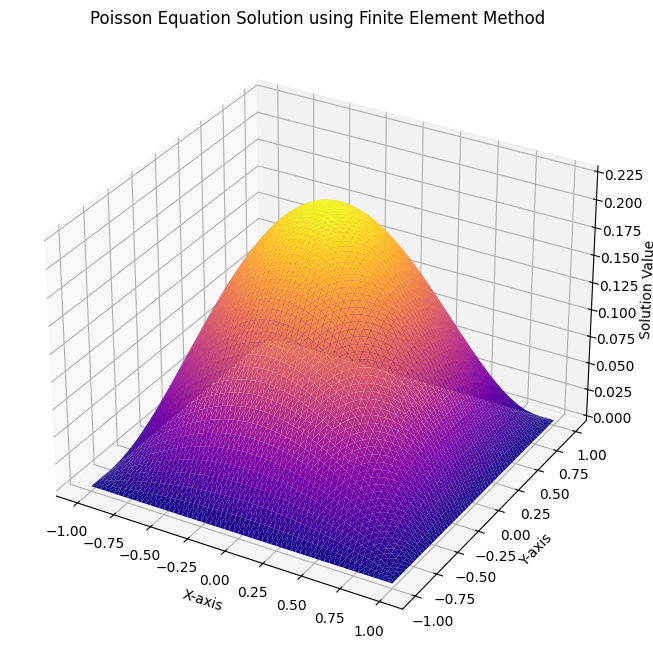

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve

def poisson_solver(refinements=6, boundary_val=0):
    ############# Mesh Generation ##########
    def subdivide_mesh(nodes, elements):
        updated_nodes = nodes.tolist()
        updated_elements = []
        midpoints = {}

        def get_midpoint_index(i, j):
            edge = tuple(sorted((i, j)))
            if edge not in midpoints:
                midpoint = (nodes[edge[0]] + nodes[edge[1]]) / 2
                midpoints[edge] = len(updated_nodes)
                updated_nodes.append(midpoint.tolist())
            return midpoints[edge]

        for triangle in elements:
            i, j, k = triangle
            m1 = get_midpoint_index(i, j)
            m2 = get_midpoint_index(j, k)
            m3 = get_midpoint_index(k, i)
            updated_elements.extend([
                [i, m1, m3],
                [m1, j, m2],
                [m3, m2, k],
                [m1, m2, m3]
            ])
        return np.array(updated_nodes), np.array(updated_elements)

    initial_nodes = np.array([
        [-1, -1],
        [ 0, -1],
        [ 1, -1],
        [-1,  0],
        [ 0,  0],
        [ 1,  0],
        [-1,  1],
        [ 0,  1],
        [ 1,  1]
    ])

    initial_elements = np.array([
        [4, 1, 5],
        [2, 5, 1],
        [5, 2, 6],
        [3, 6, 2],
        [7, 4, 8],
        [5, 8, 4],
        [8, 5, 9],
        [6, 9, 5]
    ]) - 1 

    for _ in range(refinements):
        initial_nodes, initial_elements = subdivide_mesh(initial_nodes, initial_elements)

    ############# Boundary Nodes ##########
    def identify_boundary_nodes(nodes, elements, flag):
        edges = []
        for triangle in elements:
            edges.append(tuple(sorted([triangle[0], triangle[1]])))
            edges.append(tuple(sorted([triangle[1], triangle[2]])))
            edges.append(tuple(sorted([triangle[2], triangle[0]])))

        from collections import Counter
        edge_count = Counter(edges)
        boundary_edges = [edge for edge, count in edge_count.items() if count == 1]
        boundary_indices = set()
        for edge in boundary_edges:
            boundary_indices.update(edge)

        boundary_info = np.array([
            [flag] * len(boundary_indices),
            list(boundary_indices)
        ])
        return boundary_info

    boundary_flag = -1
    boundary_nodes_info = identify_boundary_nodes(initial_nodes, initial_elements, boundary_flag)

    ############# Assemble Matrix ##########
    def local_matrix_assembly(points):
        local_matrix = np.zeros((3, 3))
        diff = np.array([
            points[0, :] - points[2, :],
            points[1, :] - points[2, :]
        ])
        gradients = np.array([[1, 0], [0, 1], [-1, -1]]).T
        area = 0.5 * np.abs(np.linalg.det(diff))
        for i in range(3):
            for j in range(3):
                B1 = np.linalg.solve(diff, gradients[:, i])
                B2 = np.linalg.solve(diff, gradients[:, j])
                local_matrix[i, j] = area * np.inner(B1, B2)
        return local_matrix

    def assemble_global_matrix(nodes, elements):
        num_nodes = len(nodes)
        data = []
        row_indices = []
        col_indices = []
        for triangle in elements:
            points = nodes[triangle, :]
            local_matrix = local_matrix_assembly(points)
            for i in range(3):
                for j in range(3):
                    data.append(local_matrix[i, j])
                    row_indices.append(triangle[i])
                    col_indices.append(triangle[j])

        global_matrix = coo_matrix((data, (row_indices, col_indices)), shape=(num_nodes, num_nodes))
        return global_matrix

    ############# Assemble Right-Hand Side ##########
    def assemble_rhs(nodes, elements, source_func):
        rhs_vector = np.zeros(len(nodes))
        for triangle in elements:
            points = nodes[triangle, :]
            area = 0.5 * np.abs(np.linalg.det(np.array([
                [1, points[0, 0], points[0, 1]],
                [1, points[1, 0], points[1, 1]],
                [1, points[2, 0], points[2, 1]]
            ])))
            for i in range(3):
                rhs_vector[triangle[i]] += source_func(*points[i]) * area / 3
        return rhs_vector

    # Define the source term
    def source_term(x, y):
        return np.exp(-x**2 - y**2)

    rhs_vector = assemble_rhs(initial_nodes, initial_elements, source_term)

    ############# Apply Boundary Conditions ##########
    def apply_boundary(A, b, boundary_info, boundary_val=0):
        A = A.tolil()  
        for flag, node_idx in zip(boundary_info[0], boundary_info[1]):
            if flag == -1:  
                A[node_idx, :] = 0
                A[:, node_idx] = 0
                A[node_idx, node_idx] = 1
                b[node_idx] = boundary_val
        return A.tocoo(), b

    # Assemble the global matrix
    global_matrix = assemble_global_matrix(initial_nodes, initial_elements)

    # Apply boundary conditions
    global_matrix, rhs_vector = apply_boundary(global_matrix, rhs_vector, boundary_nodes_info, boundary_val)

    ############# Solve the System ##########
    solution = spsolve(global_matrix, rhs_vector)

    ############# Visualize the Solution in 3D ##########
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Prepare triangulation and data for plotting
    triangulation = tri.Triangulation(initial_nodes[:, 0], initial_nodes[:, 1], initial_elements)
    x_coords = initial_nodes[:, 0]
    y_coords = initial_nodes[:, 1]
    z_values = solution  

    # Plot the 3D surface
    ax.plot_trisurf(x_coords, y_coords, z_values, triangles=initial_elements, cmap='plasma', edgecolor='none')

    # Add labels and title
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Solution Value')
    plt.title('Poisson Equation Solution using Finite Element Method')
    plt.show()

# Run the modified function
poisson_solver(refinements=5, boundary_val=0)
